In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Optional: move to the desired location:
%cd drive/My Drive/Colab/Shaki_Vai

Mounted at /content/drive
/content/drive/My Drive/Colab/Shaki_Vai


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!pip install HydroErr
import HydroErr as he
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.models import load_model

  Preparing metadata (setup.py) ... done
  Created wheel for HydroErr: filename=HydroErr-1.24-py3-none-any.whl size=20183 sha256=737c2f979f545172a79e06e85558982050f3beb6972943d215625cd3398c99ad
  Stored in directory: /root/.cache/pip/wheels/8d/e9/18/d0b606eee232002e55f79178ae1077fb4bb082600f70cfe383
Successfully built HydroErr


In [3]:
df=pd.read_csv('Data/SS.09 from 1981-2017.csv')
df.head()

,Date,yt,yt-1,yt-2,yt-3,yt-4,yt-5,yt-6,yt-7,yt-8,...,CR-3,CR-4,CR-5,CR-6,CR-7,CR-8,CR-9,CR-10,CR-11,CR-12
0,01-01-1981,11.16,11.37,11.24,10.22,9.39,8.76,8.70,8.75,8.86,...,215.0,464.0,1033.0,1773.0,2033.5,2326.0,2444.0,2626.5,2654.5,2763.0
1,02-01-1981,10.76,11.16,11.37,11.24,10.22,9.39,8.76,8.70,8.75,...,79.0,245.0,494.0,1063.0,1803.0,2063.5,2356.0,2474.0,2656.5,2684.5
2,03-01-1981,10.39,10.76,11.16,11.37,11.24,10.22,9.39,8.76,8.70,...,148.0,160.5,326.5,575.5,1144.5,1884.5,2145.0,2437.5,2555.5,2738.0
3,04-01-1981,10.07,10.39,10.76,11.16,11.37,11.24,10.22,9.39,8.76,...,241.5,278.0,290.5,456.5,705.5,1274.5,2014.5,2275.0,2567.5,2685.5
4,05-01-1981,9.82,10.07,10.39,10.76,11.16,11.37,11.24,10.22,9.39,...,347.5,377.5,414.0,426.5,592.5,841.5,1410.5,2150.5,2411.0,2703.5


### Data Set Preperation
First splitting the date as day, month, year to use as a feature in the dataset. Then setting Date Time as index and droping date, & day. As day is same for all the data

In [4]:
df['Date Time'] = pd.to_datetime(df['Date'], dayfirst=False)
df['Day'] = df['Date Time'].dt.day
df['Month'] = df['Date Time'].dt.month
df['Year'] = df['Date Time'].dt.year
df.set_index('Date Time', inplace=True)
df.drop(['Date'], axis=1, inplace=True)
df.drop(['Day'], axis=1, inplace=True)
df.head()

,yt,yt-1,yt-2,yt-3,yt-4,yt-5,yt-6,yt-7,yt-8,yt-9,...,CR-5,CR-6,CR-7,CR-8,CR-9,CR-10,CR-11,CR-12,Month,Year
Date Time,,,,,,,,,,,,,,,,,,,,,
1981-01-01,11.16,11.37,11.24,10.22,9.39,8.76,8.70,8.75,8.86,9.00,...,1033.0,1773.0,2033.5,2326.0,2444.0,2626.5,2654.5,2763.0,1,1981
1981-02-01,10.76,11.16,11.37,11.24,10.22,9.39,8.76,8.70,8.75,8.86,...,494.0,1063.0,1803.0,2063.5,2356.0,2474.0,2656.5,2684.5,2,1981
1981-03-01,10.39,10.76,11.16,11.37,11.24,10.22,9.39,8.76,8.70,8.75,...,326.5,575.5,1144.5,1884.5,2145.0,2437.5,2555.5,2738.0,3,1981
1981-04-01,10.07,10.39,10.76,11.16,11.37,11.24,10.22,9.39,8.76,8.70,...,290.5,456.5,705.5,1274.5,2014.5,2275.0,2567.5,2685.5,4,1981
1981-05-01,9.82,10.07,10.39,10.76,11.16,11.37,11.24,10.22,9.39,8.76,...,414.0,426.5,592.5,841.5,1410.5,2150.5,2411.0,2703.5,5,1981


### Feature Selection
Using Mutual Information Score to select feauters from the dataset.

            Mutual Information Score
yt                          4.541591
yt-1                        1.200388
yt-2                        0.601616
Month                       0.430210
TmeanLag11                  0.405772
TmeanLag4                   0.399656
yt-12                       0.386102
TmeanLag10                  0.380739
CR-9                        0.356847
CR-10                       0.345147
yt-3                        0.333179
CR-8                        0.308138
TmeanLag5                   0.305056
TmeanLag12                  0.286915
CR-11                       0.283990
TmeanLag6                   0.261690
yt-11                       0.234302
TmeanLag9                   0.204908
RLag-6                      0.198864
TmeanLag7                   0.192954


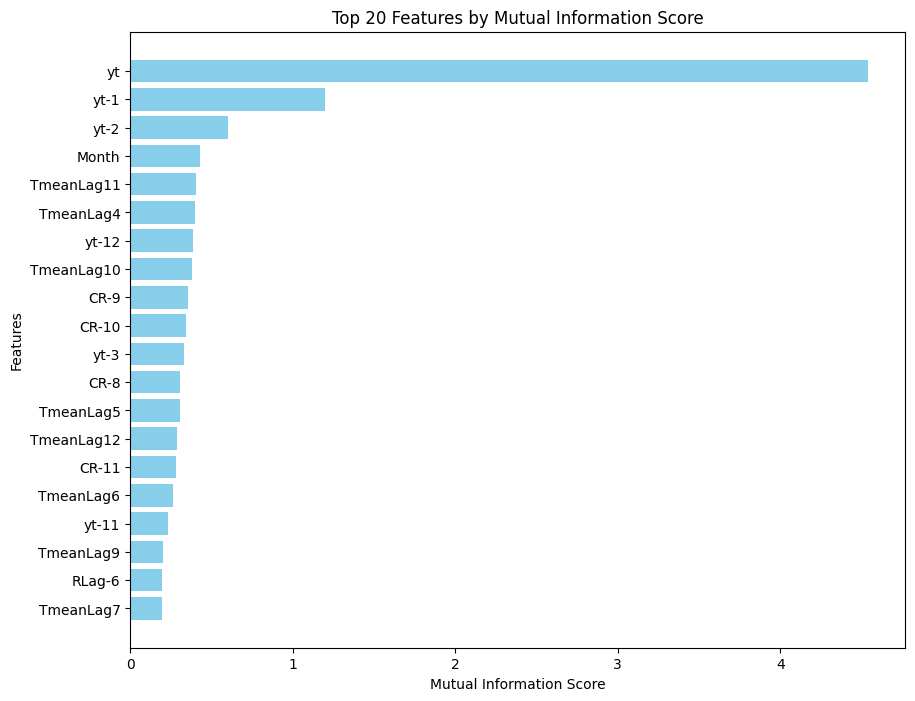

In [5]:
X = df  # Features (including luding the target)
y = df['yt']  # Target variable
# Compute mutual information
mutual_info = mutual_info_regression(X, y)
# Create a DataFrame to display the mutual information scores for each feature
mi_scores_df = pd.DataFrame(mutual_info, index=X.columns, columns=['Mutual Information Score'])
# Sort the DataFrame by mutual information score in descending order
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information Score', ascending=False)

print(mi_scores_df.head(20))
# Get the top 20 features
top_features = mi_scores_df.head(20)

# Plot the horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top_features.index, top_features['Mutual Information Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Top 20 Features by Mutual Information Score')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest score at the top
plt.show()

In [6]:
# Select dataset with top  Mutual Information Scores
dataset_top30 = df.loc[:, mi_scores_df.index[:30]]
dataset_top20 = df.loc[:, mi_scores_df.index[:20]]
dataset_top15 = df.loc[:, mi_scores_df.index[:15]]
dataset_top10 = df.loc[:, mi_scores_df.index[:10]]
dataset_top9 = df.loc[:, mi_scores_df.index[:9]]
dataset_top8 = df.loc[:, mi_scores_df.index[:8]]
dataset_top6 = df.loc[:, mi_scores_df.index[:6]]
# Print the shapes of the datasets
print("Dataset_top20:", dataset_top20.shape)
print("Dataset_top15:", dataset_top15.shape)
print("Dataset_top10:", dataset_top10.shape)
print("Dataset_top9:", dataset_top9.shape)
print("Dataset_top8:", dataset_top8.shape)
print("Dataset_top6:", dataset_top6.shape)

Dataset_top20: (444, 20)
Dataset_top15: (444, 15)
Dataset_top10: (444, 10)
Dataset_top9: (444, 9)
Dataset_top8: (444, 8)
Dataset_top6: (444, 6)


In [7]:
dataset_top8 = df[['yt','yt-1','yt-2','TmeanLag10','CR-9','yt-12','yt-3','TmeanLag5']]

from sklearn.preprocessing import StandardScaler
# Define function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
# Define function to train and evaluate model
def train_and_evaluate_model(dataset_name, dataset):
    # Split data into features and target
    X = dataset  # Adjust 'target_column' to the name of your target column
    y = dataset['yt']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)   
    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape input data for LSTM
    X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
  
    # Create and compile LSTM model
    input_shape = (X_train_reshaped.shape[1], 1)
    model = create_lstm_model(input_shape)
    
    # Train model
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, verbose=0)
    
    # Evaluate model
    y_pred = model.predict(X_test_reshaped)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE for {dataset_name}: {rmse}")

# Train and evaluate models for each dataset
train_and_evaluate_model("dataset_top15", dataset_top15)
train_and_evaluate_model("dataset_top10", dataset_top10)
train_and_evaluate_model("dataset_top9", dataset_top9)
train_and_evaluate_model("dataset_top8", dataset_top8)
train_and_evaluate_model("dataset_top6", dataset_top6)


In [8]:
# Define window size (number of time steps)

def generate_time_series_data(df, window_size, step):

    # Define lists to store features and target
    X_features = []
    y_target = []

    # Iterate over each row in the DataFrame
    for i in range(df.shape[0] - window_size-step):
        # Extract the features for the current window
        window_features = []
        for j in range(window_size):
            window_features.append(df.iloc[i + j, :].values)
        X_features.append(window_features)

        # Append the target value (12 time steps ahead) to the target list
        y_target.append(df.iloc[i + window_size + step, 0])  # Assuming the target is in the first column

    # Convert lists to numpy arrays
    X = np.array(X_features)
    y_target = np.array(y_target)
    y=np.reshape(y_target, (len(y_target),1))
    # Print the shapes of X and y
    return X, y

### Dataset preperation for 1 month ahead prediction

In [9]:
window_size = 1
step = 0
data_8, target_8= generate_time_series_data(dataset_top8, window_size, step)

### LSTM model Creation

In [10]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

callbacks = [EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)]

def create_model(batch_size=16, optimizer='SGD', activation='leaky_relu', dropout_rate=0.2, lstm_units=128, dense_units=64, seed_value=42):
    np.random.seed(seed_value)  # Set seed for NumPy
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(window_size, n_features)))

    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.5))
    else:
        model.add(Activation(activation))

    model.add(LSTM(lstm_units, return_sequences=True))

    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation(activation))

    model.add(Dropout(dropout_rate))
    model.add(LSTM(int(lstm_units/2), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units))
    model.add(Dense(1))

    if optimizer == 'SGD':
        optimizer = SGD()
    elif optimizer == 'RMSprop':
        optimizer = RMSprop()
    elif optimizer == 'Adam':
        optimizer = Adam()

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', rmse])

    return model

### MinMax scaling the data

In [11]:
def scale_data(features, target):
    # Reshape the features data to 2D (samples * time steps, features) for scaling
    features_2d = features.reshape(-1, features.shape[-1])
    # Apply MinMaxScaler to features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features_2d)
    # Apply MinMaxScaler to target
    scaled_target = scaler.fit_transform(target)
    # Reshape the scaled features data back to 3D (samples, time steps, features)
    scaled_features = scaled_features.reshape(features.shape)
    return scaled_features, scaled_target


In [12]:
# Reshape the features data to 2D (samples * time steps, features) for scaling
features_2d = data_8.reshape(-1, data_8.shape[-1])
# Apply MinMaxScaler to features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features_2d)
# Apply MinMaxScaler to target
target_1 = scaler.fit_transform(target_8)
# Reshape the scaled features data back to 3D (samples, time steps, features)
dataset_1 = scaled_features.reshape(data_8.shape)

In [13]:
#dataset_1, target_1 = scale_data(data_6, target_6)
X_train, X_test = dataset_1[:-65], dataset_1[-65:]
y_train, y_test = target_1[:-65], target_1[-65:]
n_features= X_train.shape[2]
n_features

8

In [14]:
import time
# Create the model using the best parameters
best_model = create_model(batch_size=8, lstm_units=128, dropout_rate=0.1, dense_units=64, optimizer='Adam', activation=LeakyReLU(alpha=0.27))
# Start the timer
start_time = time.time()
# Train the model with the entire training data
history = best_model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=8, callbacks=callbacks)
# End the timer
end_time = time.time()
# Calculate the elapsed time
training_time = end_time - start_time
# Evaluate the model on the test data
loss, mae, rmse = best_model.evaluate(X_test, y_test)
print("Training time:", training_time, "seconds")
print("Train Loss:", loss)
print("Train MAE:", mae)
print("Train RMSE:", rmse)

Epoch 1/100
43/43 [==============================] - 20s 127ms/step - loss: 0.0437 - mae: 0.1596 - rmse: 0.1900 - val_loss: 0.0128 - val_mae: 0.1028 - val_rmse: 0.1112
Epoch 2/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0106 - mae: 0.0809 - rmse: 0.0992 - val_loss: 0.0075 - val_mae: 0.0667 - val_rmse: 0.0853
Epoch 3/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0069 - mae: 0.0647 - rmse: 0.0788 - val_loss: 0.0030 - val_mae: 0.0440 - val_rmse: 0.0544
Epoch 4/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0035 - mae: 0.0448 - rmse: 0.0553 - val_loss: 0.0017 - val_mae: 0.0322 - val_rmse: 0.0397
Epoch 5/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0025 - mae: 0.0373 - rmse: 0.0470 - val_loss: 0.0027 - val_mae: 0.0416 - val_rmse: 0.0498
Epoch 6/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0024 - mae: 0.0378 - rmse: 0.0460 - val_loss: 9.3089e-04 - val_mae: 0.0264 - val_rmse: 0.030

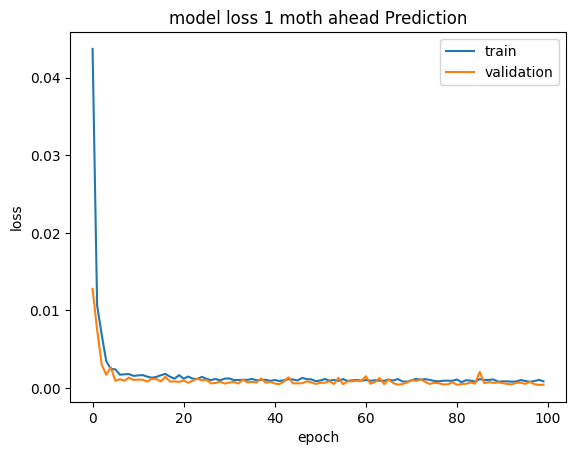

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss 1 moth ahead Prediction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions':predictions_1d, 'Actuals':y_test_1d})
test_results

3/3 [==============================] - 1s 6ms/step


,Test Predictions,Actuals
0,9.155893,9.100000
1,9.764564,10.030000
2,10.353526,10.810000
3,10.870216,11.030000
4,10.941200,10.960000
...,...,...
60,9.320305,9.320000
61,9.528921,9.830000
62,9.947569,10.030000
63,10.091042,10.170000


Mean Squared Error (MSE): 0.03
Mean Absolute Error (MAE): 0.11
Root Mean Squared Error (RMSE): 0.16
R-squared (R2) Score: 0.93
NSE Score: 0.93
KGE_12 Score: 0.88


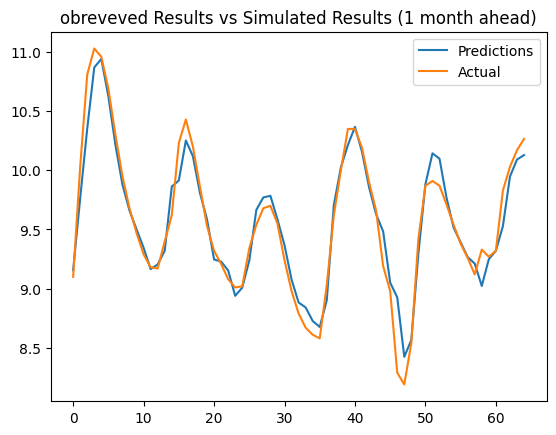

In [17]:
y_true = test_results['Actuals']
y_pred = test_results['Test Predictions']
# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
NSE1=he.nse(y_pred, y_true)
KGE_12= he.kge_2012(y_pred, y_true)
print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("Mean Absolute Error (MAE): {:.2f}".format(mae))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("R-squared (R2) Score: {:.2f}".format(r2))
print("NSE Score: {:.2f}".format(NSE1))
print("KGE_12 Score: {:.2f}".format(KGE_12))
# Visualize results
import matplotlib.pyplot as plt
plt.plot(y_pred, label='Predictions')
plt.plot(y_true, label='Actual')
plt.title('obreveved Results vs Simulated Results (1 month ahead)')
plt.legend()
plt.show()

In [19]:
from keras.models import load_model

# Define file paths for saving and loading the model
model_path = 'Models/best_model_09.keras'

# Save the trained model
best_model.save(model_path)
print("Model saved successfully.")


Model saved successfully.


### Dataset preperation for 2 month ahead prediction

In [ ]:
window_size=2
step=1
data_8_2, target_8_2= generate_time_series_data(dataset_top15, window_size,step)

In [ ]:
dataset_1, target_1 = scale_data(data_8_2, target_8_2)
X_train, X_test = dataset_1[:-65], dataset_1[-65:]
y_train, y_test = target_1[:-65], target_1[-65:]
n_features= X_train.shape[2]
n_features

15

### 2 month ahead Prediction

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

import time
# Create the model using the best parameters
best_model_1 = create_model( batch_size=8,lstm_units=128, dropout_rate=0.2, dense_units=64, optimizer='Adam', activation=LeakyReLU(alpha=0.2))
# Start the timer
start_time = time.time()
# Train the model with the entire training data
history = best_model_1.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=8, callbacks=callbacks)
# End the timer
end_time = time.time()
# Calculate the elapsed time
training_time = end_time - start_time
# Evaluate the model on the test data
loss, mae, rmse = best_model_1.evaluate(X_test, y_test)
print("Training time:", training_time, "seconds")
print("Train Loss:", loss)
print("Train MAE:", mae)
print("Train RMSE:", rmse)

Epoch 1/100
38/38 [==============================] - 5s 24ms/step - loss: 0.0373 - mae: 0.1465 - rmse: 0.1748 - val_loss: 0.0161 - val_mae: 0.1128 - val_rmse: 0.1219
Epoch 2/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0132 - mae: 0.0882 - rmse: 0.1097 - val_loss: 0.0118 - val_mae: 0.0959 - val_rmse: 0.1074
Epoch 3/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0699 - rmse: 0.0850 - val_loss: 0.0038 - val_mae: 0.0474 - val_rmse: 0.0559
Epoch 4/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0062 - mae: 0.0616 - rmse: 0.0746 - val_loss: 0.0104 - val_mae: 0.0917 - val_rmse: 0.0990
Epoch 5/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0059 - mae: 0.0587 - rmse: 0.0723 - val_loss: 0.0045 - val_mae: 0.0593 - val_rmse: 0.0658
Epoch 6/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0052 - mae: 0.0540 - rmse: 0.0685 - val_loss: 0.0040 - val_mae: 0.0488 - val_rmse: 0.0569
Epoch 7/1

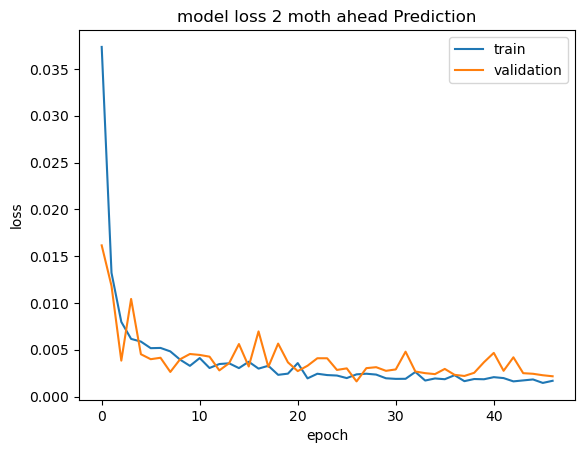

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss 2 moth ahead Prediction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
predictions = best_model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions':predictions_1d, 'Actuals':y_test_1d})
test_results

3/3 [==============================] - 1s 6ms/step


,Test Predictions,Actuals
0,8.983808,9.100000
1,9.798806,10.030000
2,10.351737,10.810000
3,10.684607,11.030000
4,10.933135,10.960000
...,...,...
60,9.020578,9.320000
61,9.319203,9.830000
62,9.789651,10.030000
63,10.073617,10.170000


Mean Squared Error (MSE): 0.05
Mean Absolute Error (MAE): 0.16
Root Mean Squared Error (RMSE): 0.23
R-squared (R2) Score: 0.86
NSE Score: 0.86
KGE_12 Score: 0.90


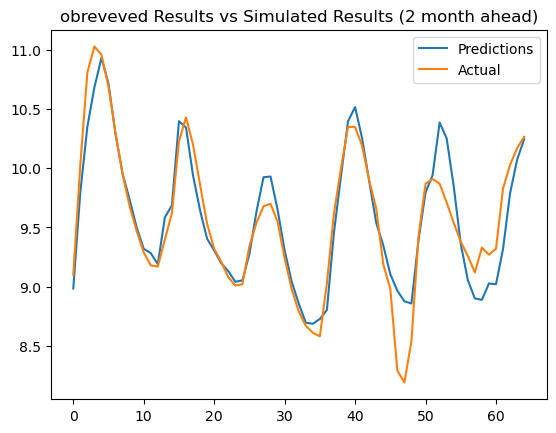

In [ ]:
y_true = test_results['Actuals']
y_pred = test_results['Test Predictions']
# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
NSE1=he.nse(y_pred, y_true)
KGE_12= he.kge_2012(y_pred, y_true)
print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("Mean Absolute Error (MAE): {:.2f}".format(mae))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("R-squared (R2) Score: {:.2f}".format(r2))
print("NSE Score: {:.2f}".format(NSE1))
print("KGE_12 Score: {:.2f}".format(KGE_12))
# Visualize results
import matplotlib.pyplot as plt
plt.plot(y_pred, label='Predictions')
plt.plot(y_true, label='Actual')
plt.title('obreveved Results vs Simulated Results (2 month ahead)')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

# Define file paths for saving and loading the model
model_path = 'best_model_1.h5'

# Save the trained model
best_model_1.save(model_path)
print("Model saved successfully.")

Model saved successfully.


### Dataset preperation for 3 month ahead prediction

In [ ]:
window_size = 2
step=2
data_8_3, target_8_3= generate_time_series_data(dataset_top8, window_size,step)


In [ ]:
dataset_1, target_1 = scale_data(data_8_3, target_8_3)
X_train, X_test = dataset_1[:-65], dataset_1[-65:]
y_train, y_test = target_1[:-65], target_1[-65:]
n_features= X_train.shape[2]
n_features

8

### 3 month ahead Prediction

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
import time
# Create the model using the best parameters
best_model_2 = create_model( batch_size=8,lstm_units=128,dropout_rate=0.2, dense_units=64, optimizer='Adam', activation=LeakyReLU(alpha=0.2))
# Start the timer
start_time = time.time()
# Train the model with the entire training data
history = best_model_2.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=8, callbacks=callbacks)
# End the timer
end_time = time.time()
# Calculate the elapsed time
training_time = end_time - start_time
# Evaluate the model on the test data
loss, mae, rmse = best_model_2.evaluate(X_test, y_test)
print("Training time:", training_time, "seconds")
print("Train Loss:", loss)
print("Train MAE:", mae)
print("Train RMSE:", rmse)

Epoch 1/100
38/38 [==============================] - 4s 24ms/step - loss: 0.0473 - mae: 0.1655 - rmse: 0.1966 - val_loss: 0.0241 - val_mae: 0.1333 - val_rmse: 0.1500
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0255 - mae: 0.1248 - rmse: 0.1540 - val_loss: 0.0211 - val_mae: 0.1229 - val_rmse: 0.1407
Epoch 3/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0195 - mae: 0.1093 - rmse: 0.1324 - val_loss: 0.0132 - val_mae: 0.0971 - val_rmse: 0.1135
Epoch 4/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0098 - mae: 0.0748 - rmse: 0.0936 - val_loss: 0.0081 - val_mae: 0.0680 - val_rmse: 0.0820
Epoch 5/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0083 - mae: 0.0679 - rmse: 0.0855 - val_loss: 0.0078 - val_mae: 0.0692 - val_rmse: 0.0809
Epoch 6/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0072 - mae: 0.0602 - rmse: 0.0771 - val_loss: 0.0093 - val_mae: 0.0677 - val_rmse: 0.0812
Epoch 7/1

38/38 [==============================] - 0s 7ms/step - loss: 0.0039 - mae: 0.0426 - rmse: 0.0559 - val_loss: 0.0053 - val_mae: 0.0493 - val_rmse: 0.0632
Epoch 51/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0032 - mae: 0.0401 - rmse: 0.0526 - val_loss: 0.0070 - val_mae: 0.0572 - val_rmse: 0.0707
Epoch 52/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0034 - mae: 0.0411 - rmse: 0.0539 - val_loss: 0.0091 - val_mae: 0.0711 - val_rmse: 0.0837
Epoch 53/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0035 - mae: 0.0404 - rmse: 0.0535 - val_loss: 0.0059 - val_mae: 0.0548 - val_rmse: 0.0665
Epoch 54/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0031 - mae: 0.0383 - rmse: 0.0499 - val_loss: 0.0093 - val_mae: 0.0723 - val_rmse: 0.0853
Epoch 55/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0033 - mae: 0.0388 - rmse: 0.0501 - val_loss: 0.0072 - val_mae: 0.0582 - val_rmse: 0.0732
Epoch 56/100
38/3

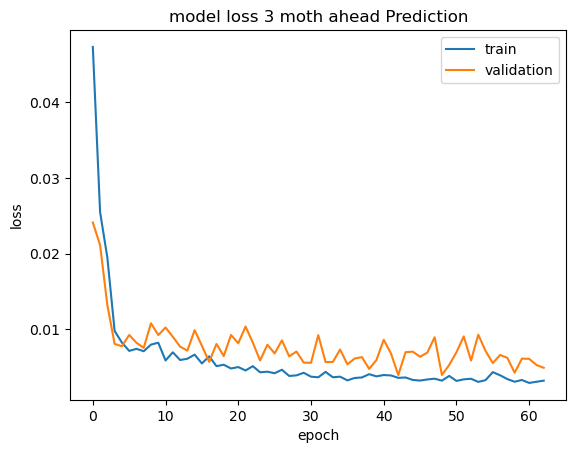

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss 3 moth ahead Prediction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
predictions = best_model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions':predictions_1d, 'Actuals':y_test_1d})
test_results

3/3 [==============================] - 1s 8ms/step


,Test Predictions,Actuals
0,9.015687,9.100000
1,9.387570,10.030000
2,10.316623,10.810000
3,10.768077,11.030000
4,10.838395,10.960000
...,...,...
60,9.085044,9.320000
61,9.593769,9.830000
62,9.805486,10.030000
63,10.258634,10.170000


Mean Squared Error (MSE): 0.07
Mean Absolute Error (MAE): 0.21
Root Mean Squared Error (RMSE): 0.27
R-squared (R2) Score: 0.80
NSE Score: 0.80
KGE_12 Score: 0.88


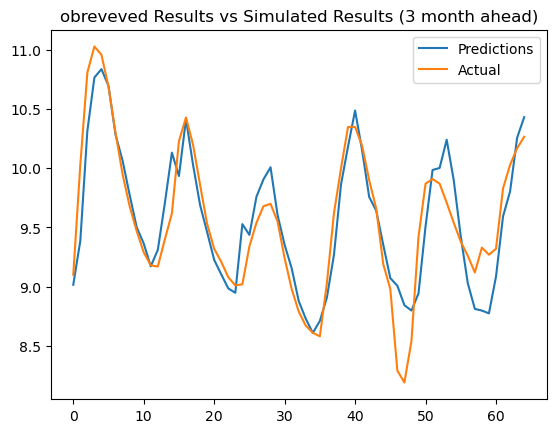

In [ ]:
y_true = test_results['Actuals']
y_pred = test_results['Test Predictions']
# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
NSE1=he.nse(y_pred, y_true)
KGE_12= he.kge_2012(y_pred, y_true)
print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("Mean Absolute Error (MAE): {:.2f}".format(mae))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("R-squared (R2) Score: {:.2f}".format(r2))
print("NSE Score: {:.2f}".format(NSE1))
print("KGE_12 Score: {:.2f}".format(KGE_12))
# Visualize results
import matplotlib.pyplot as plt
plt.plot(y_pred, label='Predictions')
plt.plot(y_true, label='Actual')
plt.title('obreveved Results vs Simulated Results (3 month ahead)')
plt.legend()
plt.show()

In [ ]:
# Define file paths for saving and loading the model
model_path = 'best_model_2.h5'

# Save the trained model
best_model_2.save(model_path)
print("Model saved successfully.")

Model saved successfully.
